Chao formula Eq.6.207  https://www.slac.stanford.edu/~achao/WileyBook/WileyChapter6.pdf
CGS units are used. 

In [1]:
import numpy as np
from scipy.constants import m_p, c, e
import matplotlib.pyplot as plt

### Load the impedance data (use only of dipolar kick)

In [72]:
## Choose plane of interest
plane = 'y' # 'x' or 'y'

if plane == 'x':
    column_select_dipolar, column_select_quad = 1, 3
    legend_Im = r'$\mathrm{Im(Z_x)}$'
    legend_Re = r'$\mathrm{Re(Z_x)}$'
    y_label = r'$\mathrm{Z_x \ [\Omega /m]}$'
    Q_b = 26.13 # betatron tune
    
if plane == 'y':
    column_select_dipolar, column_select_quad = 2, 4
    legend_Im = r'$\mathrm{Im(Z_y)}$'
    legend_Re = r'$\mathrm{Re(Z_y)}$'
    y_label = r'$\mathrm{Z_y \ [\Omega /m]}$'
    Q_b = 26.18 #20.22 # betatron tune

In [73]:
#### Impedance model from https://gitlab.cern.ch/IRIS/SPS_IW_model/-/tree/master/SPS_IW_model_python ###########################################
#impedanceData = np.genfromtxt('SPS_Complete_imp_model_2018_Q26.txt', skip_header=1, dtype=complex)
#impedanceData = np.genfromtxt('./impedanceFiles/Q26/SPS_Complete_imp_model_2018_Q26.txt', skip_header=1, dtype=complex)
impedanceData = np.genfromtxt('./impedanceFiles/Q26/SPS_Complete_imp_model_2018_Q26.txt', skip_header=1, dtype=complex)


freqZ = np.real(impedanceData[:, 0]) * 1E9  # frequencies in [GHz], so probably this needs to change in 1e9

ReZ_y_dipolar = np.real(impedanceData[:, column_select_dipolar]) # dipolar kick in y-plane, always odd, -f(x) = f(-x)
ImZ_y_dipolar = np.imag(impedanceData[:, column_select_dipolar])  # dipolar kick in the y-plane, always even (f-x) = f(x)

ReZ_y_quad = np.real(impedanceData[:, column_select_quad]) 
ImZ_y_quad = np.imag(impedanceData[:, column_select_quad])  


'''
# A1. Plot vertical impedances (dipolar kick only)
plt.plot(freqZ, ImZ_y_dipolar, label=legend_Im)
plt.plot(freqZ, ReZ_y_dipolar, label=legend_Re)
plt.xlabel('Frequency [Hz]')
plt.ylabel(y_label)
plt.legend()
plt.grid(ls='--')
plt.ylim(-0.5e7, 0.5e8)
plt.show()
'''

"\n# A1. Plot vertical impedances (dipolar kick only)\nplt.plot(freqZ, ImZ_y_dipolar, label=legend_Im)\nplt.plot(freqZ, ReZ_y_dipolar, label=legend_Re)\nplt.xlabel('Frequency [Hz]')\nplt.ylabel(y_label)\nplt.legend()\nplt.grid(ls='--')\nplt.ylim(-0.5e7, 0.5e8)\nplt.show()\n"

### Plot again vs angular frequency

In [74]:
omegaZ = 2*np.pi*freqZ
'''
# A2. Plot vertical impedances (dipolar kick only)
plt.plot(omegaZ, ImZ, label=legend_Im)
plt.plot(omegaZ, ReZ, label=legend_Re)
plt.xlabel('Angular frequency [rad]')
plt.ylabel(y_label)
plt.legend()
plt.grid(ls='--')
plt.ylim(-0.5e7, 0.5e8)
plt.show()
plt.close()
'''

"\n# A2. Plot vertical impedances (dipolar kick only)\nplt.plot(omegaZ, ImZ, label=legend_Im)\nplt.plot(omegaZ, ReZ, label=legend_Re)\nplt.xlabel('Angular frequency [rad]')\nplt.ylabel(y_label)\nplt.legend()\nplt.grid(ls='--')\nplt.ylim(-0.5e7, 0.5e8)\nplt.show()\nplt.close()\n"

### Compute the effective impedance

The effective impedance $Z_{eff}$ is described by:

$Z_{\perp eff}^{(l)} = \frac{\sum_{p=-\infty}^{+ \infty}Z_{\perp }^{(l)}(\omega_{p}) h_l(\omega_{p}-\omega_\xi)}{\sum_{p=-\infty}^{+ \infty}h_l(\omega_{p}-\omega_\xi)}$ (1)

with $\omega_p = (p+Q)\omega_0$ the discrete spectrum of the transverse bunch oscillations. $-\infty < p < + \infty$ for a single bunch (which is our case) or several bunches oscillating independently. $\omega_\xi=(\xi \omega_0)/(\eta \nu_b)$ the chromatic frequency, with $\eta$ the phase slip factor. Note that $\xi$ is the chromaticity defined as $\xi = d\nu_b/d\delta$ with $\delta=\Delta P/P_0$ the relative momentum error, and $Q^\prime=\xi/\nu_b$. Thus we can re-write $\omega_\xi=Q^\prime \omega_0 / \eta$. \textbf{Attention:} In the simulations $Q^\prime$ is referred as chromaticity.

Last, $h_l$, is the power spectral density of a Gaussian bunch of $l$ azimuthial mode. $h_l$ is described by \cite{Chao:collective} (Chapter Eq.6.143):
$h_l(\omega) = (\omega \sigma_z/c)^{2l} e^{-(\omega \sigma_z/c)^2}$ (2)
   
where $c$ is the speed of light in [m/s].

In [75]:
def hmm_gaus(omega, sigma_z, clight, l=0):
    return (omega*sigma_z/clight)**(2*l)*np.exp(-(omega*sigma_z/clight)**2)

In [76]:
# create the spectrum with discrete lines
nSideband = 350000 #int(np.floor((1E10/(f_0))))
sidebands_p = np.arange(-nSideband, nSideband+0.5)

In [77]:
l = 0 # azimuthial mode (headtail mode)
clight = c*1e2 #[cm]/[s]
circum = 2 * np.pi * 1.1E3*1e2  # [cm]
f_0 = clight / circum  # revolution frequency in Hz
omega_0 = 2 * np.pi * f_0  # angular revolution frequency
#Q_y = 26.18 # betatron tune

In [78]:
omegas = omega_0*(sidebands_p+Q_b) # the middle is not zero due to the shift of q_y

In [79]:
### compute chromatic frequency shift

In [81]:
Qp = 0.5 # chromaticity
gamma_t = 22.8  # for Q26, 18 for Q20

# Compute lorentz facotr
m0 = 0.9382720813e9 # proton rest mass, [eV/c^2]
E_rest = m0
E_0 = 200e9 #270e0 # total energy of the reference particle [eV]
gamma = E_0/E_rest
eta = 1 / gamma_t ** 2 - 1 / gamma ** 2 # slip factor
omega_xi = Qp * omega_0 / eta

#sigma_z = 27 #15.5 # [cm] 

#sigma_z = 27 #15.5 # [cm] 
tau = 2.1e-9 #1.85e-9 #2.2e-9 #1.7e-9 # 4 sigma_t [s]
sigma_z = 1e2*c*tau/4 #0.155  # [cm]

#sigma_z = 27
#sigma_z = %sigmaz #0.155
print(f'sigma_z= {sigma_z} [cm]')

sigma_z= 15.739104045000001 [cm]


Text(0, 0.5, '$h_0(\\omega_p - \\omega_\\xi)$')

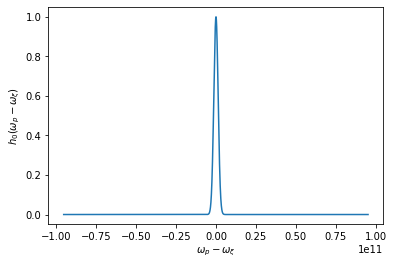

In [82]:
hs = hmm_gaus(omegas-omega_xi, sigma_z, clight=clight, l=0)
#hs = hmm_gaus_tau(omegas-omega_xi, tau)
plt.plot(omegas-omega_xi, hs)
plt.xlabel(r'$\omega_p - \omega_\xi$')
plt.ylabel(r'$h_0(\omega_p - \omega_\xi)$')

In [83]:
### Create impedance for negative frequencies and Extrapolate Zeff in the omehas

(-5000000.0, 50000000.0)

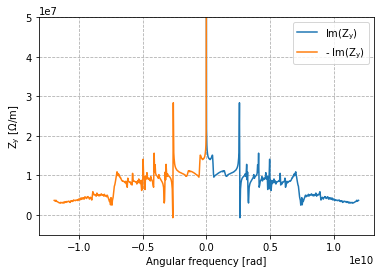

In [84]:
# ImZ is always even f(x) = f(-x)
ImZ_y_pos_dipolar = ImZ_y_dipolar
ImZ_y_neg_dipolar = ImZ_y_dipolar

ImZ_y_pos_quad = ImZ_y_quad
ImZ_y_neg_quad = ImZ_y_quad



# B. Plot vertical impedance also for negative frequencies
plt.plot(omegaZ, ImZ_y_pos_dipolar, label=legend_Im)
plt.plot(-omegaZ, ImZ_y_neg_dipolar, label='- '+legend_Im)

plt.xlabel('Angular frequency [rad]')
plt.ylabel(y_label)
plt.legend()
plt.grid(ls='--')
plt.ylim(-0.5e7, 0.5e8)

In [85]:
### Extrapolate

In [86]:
omegas_pos = list(filter(lambda x: x >= 0, omegas))
omegas_neg = list(filter(lambda x: x < 0, omegas))

ImZ_pos_interp_y_dipolar = np.interp(omegas_pos, omegaZ, ImZ_y_pos_dipolar)
ImZ_neg_interp_y_dipolar = np.interp(np.abs(omegas_neg), omegaZ, ImZ_y_neg_dipolar)

ImZ_pos_interp_y_quad = np.interp(omegas_pos, omegaZ, ImZ_y_pos_quad)
ImZ_neg_interp_y_quad = np.interp(np.abs(omegas_neg), omegaZ, ImZ_y_neg_quad)



# C1. Plot ImZ(my_omegas)
#plt.plot(omegas_pos, ImZ_pos_interp_y_dipolar, label=legend_Im)
#plt.plot(omegas_neg, ImZ_neg_interp_y_dipolar, label='- '+legend_Im )

#plt.xlabel('Angular frequency [rad]')
#plt.ylabel(y_label)
#plt.legend()
#plt.grid(ls='--')
#plt.ylim(-0.5e7, 0.5e8)
#plt.xlim(-5e10, 5e10)

In [87]:
# C2. constract and plot total impedance.

ImZ_interp_total_y_dipolar = list(ImZ_neg_interp_y_dipolar)+list(ImZ_pos_interp_y_dipolar)
ImZ_interp_total_y_quad = list(ImZ_neg_interp_y_quad)+list(ImZ_pos_interp_y_quad)


#plt.plot(omegas, ImZ_interp_total_y_dipolar, label=legend_Im)
#plt.xlabel('Angular frequency [rad]')
#plt.ylabel(y_label)
#plt.legend()
#plt.grid(ls='--')
#plt.ylim(-0.5e7, 0.5e8)
#plt.xlim(-5e10, 5e10)

In [88]:
# compute effective impedance
Zeff_nominator_dipolar = np.sum(ImZ_interp_total_y_dipolar*hs)
Zeff_denominator_dipolar = np.sum(hs)
Zeff_dipolar = Zeff_nominator_dipolar/Zeff_denominator_dipolar


Zeff_nominator_quad = np.sum(ImZ_interp_total_y_quad*hs)
Zeff_denominator_quad = np.sum(hs)
Zeff_quad = Zeff_nominator_quad/Zeff_denominator_quad

Zeff = Zeff_dipolar+Zeff_quad

print(f'Zeff = {Zeff} [Ohm/m]')

Zeff = 16098002.003983662 [Ohm/m]


### Convert in CGS units
- 1 [Ohm] = (1/9)*10**(-11) [s]/[cm]
- 1 [Ohm]/[m] = (1/9)*10**(-13) [s]/[cm]**2 

In [89]:
iZeff_cgs = Zeff*(1/9)*1e-13 #[s]/[cm]**2 iZeff of Eq.6.207

### Compute DQ (CGS units)

\begin{equation}
\Omega^{(l)}-\omega_{\beta}-l\omega_s = -\frac{1}{4\pi}\frac{\Gamma(l+1/2)}{2^l l!}\frac{N r_0 c^2}{\gamma T_0 \omega_\beta \sigma} jZ_{eff} \ \ (4)
\end{equation}

For l = 0 :

- $(\Gamma(1/2)=\sqrt{\pi}$
- $T_0 = 2\pi/\omega_0$
- $Q_y = \omega_\beta/\omega_0$

\begin{equation}
\Omega^{(l)}-\omega_{\beta} = -\frac{\sqrt{\pi}}{4\pi}\frac{N r_0 c^2}{\gamma \frac{2\pi}{\omega_0} \omega_\beta \sigma} jZ_{eff}  \ \ (5)
\end{equation}

which is written:
\begin{equation}
\Delta\Omega = -\frac{N r_0 c^2}{8\pi^{3/2}\gamma Q_b \sigma} jZ_{eff}   \ \ (6)
\end{equation}

Last, 

\begin{equation}
\Delta Q = \frac{\Delta \Omega^{(l)}}{\omega_0} \ \ (7)
\end{equation}


In [90]:
# Compute DQ
r_0 = 1.535 * 10 ** (-16) # [cm]
Nb = 3.0e10 #intensity_list[4] #3e10  # protons per bunch

### Eq.6.207 Chao, collective effects
Domega = -(Nb * r_0 * clight ** 2 * iZeff_cgs) / (8 * np.pi ** (3 / 2) * gamma * Q_b* sigma_z)
print(Domega)

DQ_coh = Domega/omega_0
print(f'DQ_coh = {DQ_coh*1e4}e-4')
#DQ = -(beta*e*I_0*Zeff)/(4*sigma_z*np.sqrt(np.pi)*omega_0**2*gamma*26.18*m_p)


-189.2059814047389
DQ_coh = -6.942355419268512e-4


In [35]:
# Compute DQ
r_0 = 1.535 * 10 ** (-16)

intensity_list = np.linspace(0, 5e10, 5) # protons per bunch
#intensity_list = np.linspace(2.5e11, 4e11, 5) # protons per bunch


DQ_coh_list = []
for Nb in intensity_list:

    ### Eq.6.207 Chao, collective effects
    Domega = -(Nb * r_0 * clight ** 2 * iZeff_cgs) / (8 * np.pi ** (3 / 2) * gamma * Q_b * sigma_z)


    DQ_coh = Domega/omega_0
    print(f'DQ_coh = {DQ_coh} ')
    DQ_coh_list.append(DQ_coh)

DQ_coh = -0.0 
DQ_coh = -0.0001368629380480437 
DQ_coh = -0.0002737258760960874 
DQ_coh = -0.00041058881414413105 
DQ_coh = -0.0005474517521921748 


In [57]:
DQ_coh_list

[-0.0,
 -8.23202333144745e-06,
 -1.64640466628949e-05,
 -2.4696069994342355e-05,
 -3.29280933257898e-05]

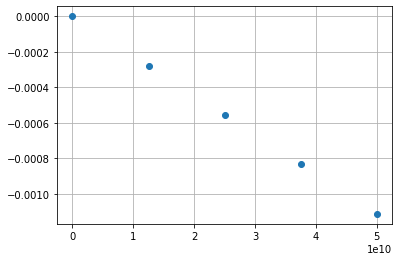

In [25]:
plt.plot(intensity_list, np.array(DQ_coh_list), 'o')
plt.xlim()
plt.grid()

In [44]:
# save in pickle files
import pickle

Q_coherent = {}
#Qx_coherent = {}
for i, intensity in enumerate(intensity_list):
    Q_coherent[f'intensity {intensity}'] = DQ_coh_list[i]
    #Qx_coherent[f'intensity {intensity}'] = Qx_list[i]
    
save2pickle = False
if save2pickle:
    with open(f'Q{plane}_coherent_vs_Intensity_Chao_QpyQpx{Qp}_steps_270GeV_Q26Complete2018_dipolQuads.pkl', 'wb') as ff:
        pickle.dump(Q_coherent, ff, pickle.HIGHEST_PROTOCOL)
    ff.close()
    
#if save2pickle:
#    with open(f'Qx_coherent_vs_Intensity_6D_ayy{app_y}_wakesON_Qpy{Qp_x}_{wakeContribution}.pkl', 'wb') as ff:
#        pickle.dump(Qx_coherent, ff, pickle.HIGHEST_PROTOCOL)
#    ff.close()